### Every-visit Monte Carlo with Exploring Starts for estimating an optimal Blackjack policy

This corresponds to the algorithm described in Chapter 5.3 of [_Reinforcement Learning: An Introduction_](http://incompleteideas.net/book/the-book-2nd.html), by Sutton and Barto.

In [1]:
import pickle
import time

import gym
import numpy as np
from tqdm import tqdm

from rl_agents.blackjack.MonteCarloAgent import MonteCarloAgent

### Initialize Blackjack agent and environment

In [168]:
RANDOM_SEED = 2

env = gym.make('Blackjack-v0')
env.seed(seed=RANDOM_SEED)
agent = MonteCarloAgent(action_space=env.action_space,
                        obs_space=env.observation_space,
                        seed=RANDOM_SEED)

### Run Experiment

In [85]:
NUM_EPISODES = 10000000  # 1 episode -> 1 game of blackjack

for i_episode in tqdm(range(NUM_EPISODES)):
    observation = env.reset()
    reward = 0
    done = False
    t = 0
    episode_ts = []
    while not done:
        action = agent.agent_step(reward=reward,
                                  observation=observation)
        observation, reward, done, info = env.step(action)
        episode_ts.append((action, observation, reward))

        if done:
            break

        t += 1

    agent.agent_end(episode_ts=episode_ts)

In [2]:
# Save the agent
with open("./agents/{}_mc_episodes={}.pkl".format(int(time.time()), NUM_EPISODES), "wb") as fp:
    pickle.dump(agent, fp)

In [3]:
# Load the agent (this agent is <1mb, and it should have an optimal policy, so it 
# will be provided in the repo).
with open("./agents/mc_episodes=10000000.pkl", "rb") as fp:
    agent = pickle.load(fp)

### Analyze agent performance

In [96]:
# Dependencies
from mpl_toolkits.mplot3d.axes3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
plt.rcParams['figure.figsize'] = [10, 10]

# Task specific plot labels
dealer_labels = ["A", "2", "3", "4", "5", "6", "7", "8", "9", "10"]
dealer_title = "Dealer Showing"
player_labels = ["11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21"]
player_title = "Player Sum"
value_title = "State Value"

# Visualization routines
def surface_plot(X, Y, Z, x_labels, y_labels, x_title, y_title, title, vmax=1.0, vmin=-1.0):
#     fig = plt.figure()
    fig = plt.figure(figsize=plt.figaspect(0.5)*1.5)
    ax = fig.gca(projection="3d")
    
    surface = ax.plot_surface(X, Y, Z,
                              cmap=cm.coolwarm, 
                              linewidth=0, 
                              antialiased=False,
                              vmax=vmax,
                              vmin=vmin)
    
    # Add a color bar
    cbar = fig.colorbar(surface)
    cbar.ax.set_title("State Value Estimate", fontsize=14)
    
    # Rotate axis
    ax.view_init(elev=30, azim=210)
    
    # Labels & Titles
    ax.set_xticks(np.arange(len(x_labels))+1.0)
    ax.set_yticks(np.arange(len(y_labels))+1.0)
    ax.set_xticklabels(x_labels)
    ax.set_xlabel(x_title, fontsize=14)
    ax.set_yticklabels(y_labels)
    ax.set_ylabel(y_title, fontsize=14)
    ax.set_title(title, fontsize=16)
    
    
#     # Attempting to increase the scale of the x-axis to improve readability
#     x_scale=3
#     y_scale=1
#     z_scale=1

#     scale=np.diag([x_scale, y_scale, z_scale, 1.0])
#     scale=scale*(1.0/scale.max())
#     scale[3,3]=1.0

#     def short_proj():
#       return np.dot(Axes3D.get_proj(ax), scale)

#     ax.get_proj=short_proj
    
    
    plt.show()
    
def gen_heatmap(values, x_labels, y_labels, x_title, y_title, title):
    fig, ax = plt.subplots()
    
    heatmap = ax.pcolor(values)
    cbar = plt.colorbar(heatmap)
    cbar.ax.set_title("HIT prob", fontsize=14)

    # Labels & Titles
    ax.set_xticks(np.arange(len(x_labels))+1.0)
    ax.set_yticks(np.arange(len(y_labels))+1.0)
    ax.set_xticklabels(x_labels)
    ax.set_xlabel(x_title, fontsize=14)
    ax.set_yticklabels(y_labels)
    ax.set_ylabel(y_title, fontsize=14)
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.set_title(title, fontsize=16)
    
    # Add padding to color bar
    
    fig.tight_layout()
    plt.show()

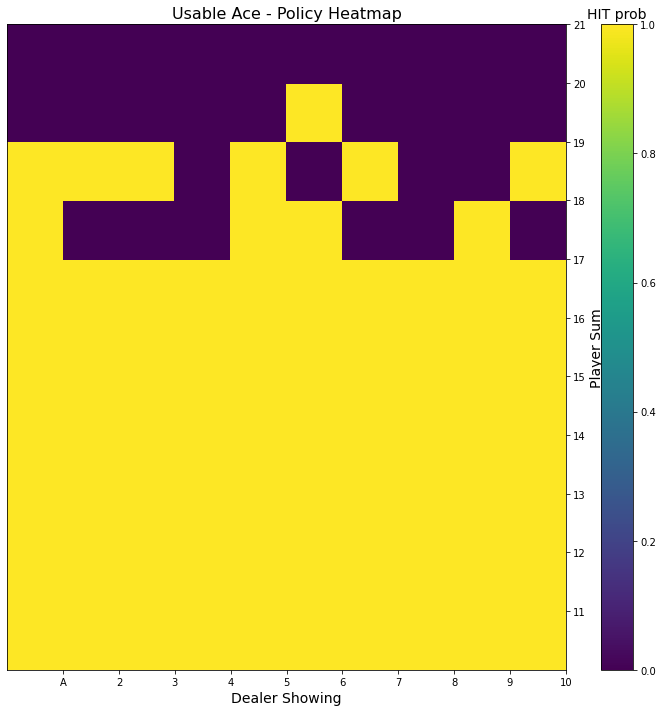

In [97]:
# Usable Ace - Policy Heatmap
policy_values = agent.policy[11:22, 1:, 1]
gen_heatmap(values=policy_values, 
            x_labels=dealer_labels, 
            y_labels=player_labels, 
            x_title=dealer_title, 
            y_title=player_title, 
            title="Usable Ace - Policy Heatmap")

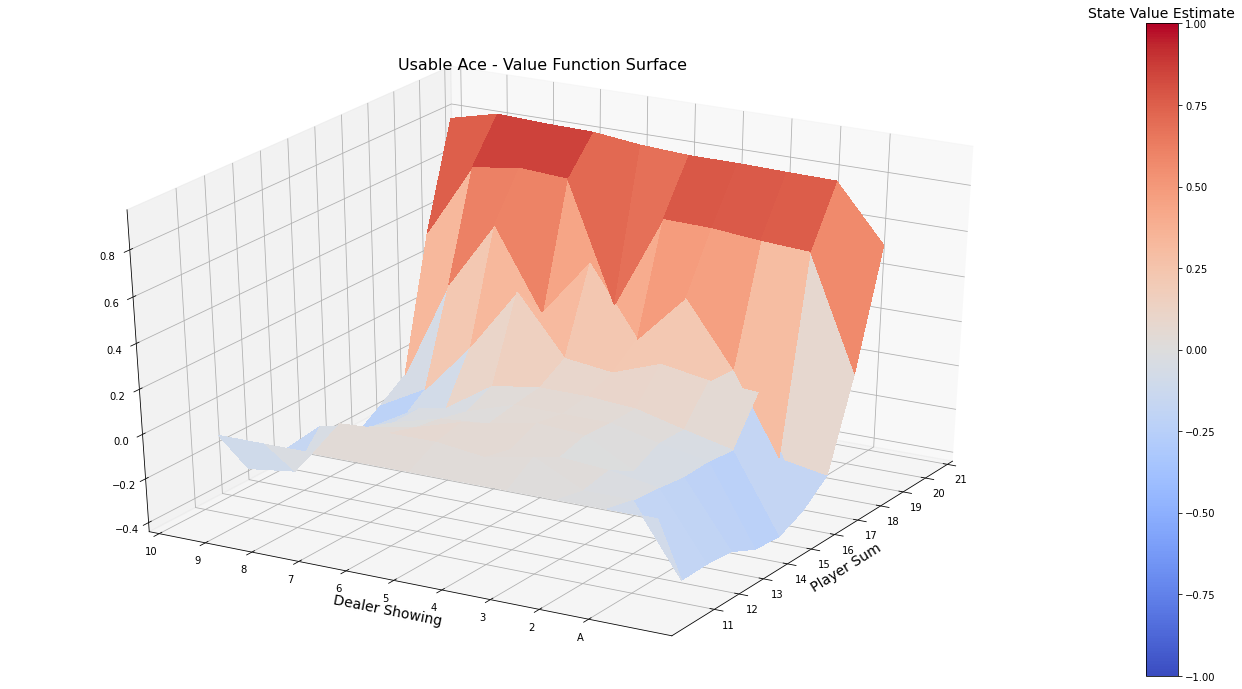

In [98]:
# Usable Ace - Value function surface

# NB: We need to use these ranges because the index in the action_value tensor 
#     corresponds to state repsentation (e.g., the action value for player_score=12, 
#     dealer_card=3, usable_ace=1 is stored at agent.action_values[12, 3, 1]).
x = np.arange(12, 22)
y = np.arange(1, 11)
X, Y = np.meshgrid(x, y)

# Estimate the value function by following our deterministic action-value maximizing policy
Z = np.amax(agent.action_values[X, Y, 1], axis=2)

# Need to recompute the X & Y meshgrids so we can properly index into the Z tensor
x = np.arange(0, 10)
y = np.arange(0, 10)
X, Y = np.meshgrid(x, y)

surface_plot(X=X,
             Y=Y,
             Z=Z,
             x_labels=player_labels, 
             y_labels=dealer_labels, 
             x_title=player_title, 
             y_title=dealer_title, 
             title="Usable Ace - Value Function Surface")

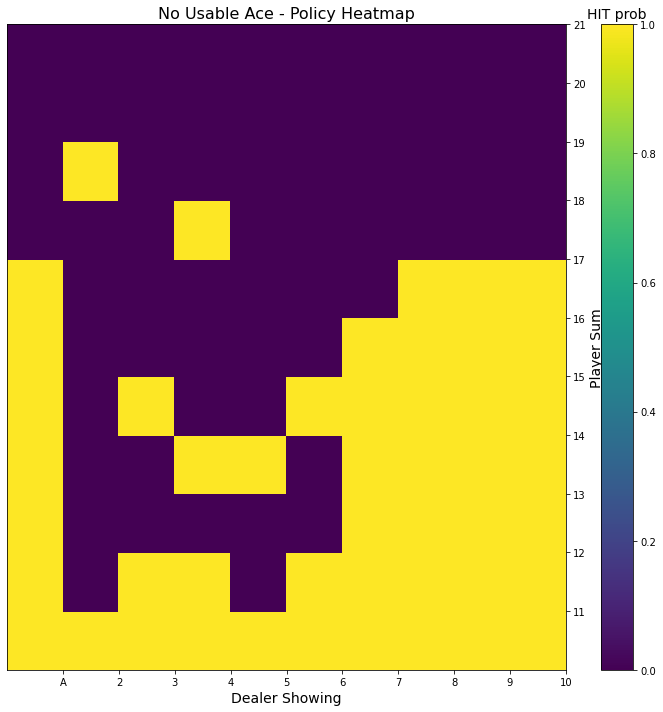

In [99]:
# No Usable Ace - Policy Heatmap
policy_values = agent.policy[11:22, 1:, 0]
gen_heatmap(values=policy_values, 
            x_labels=dealer_labels, 
            y_labels=player_labels, 
            x_title=dealer_title, 
            y_title=player_title, 
            title="No Usable Ace - Policy Heatmap")

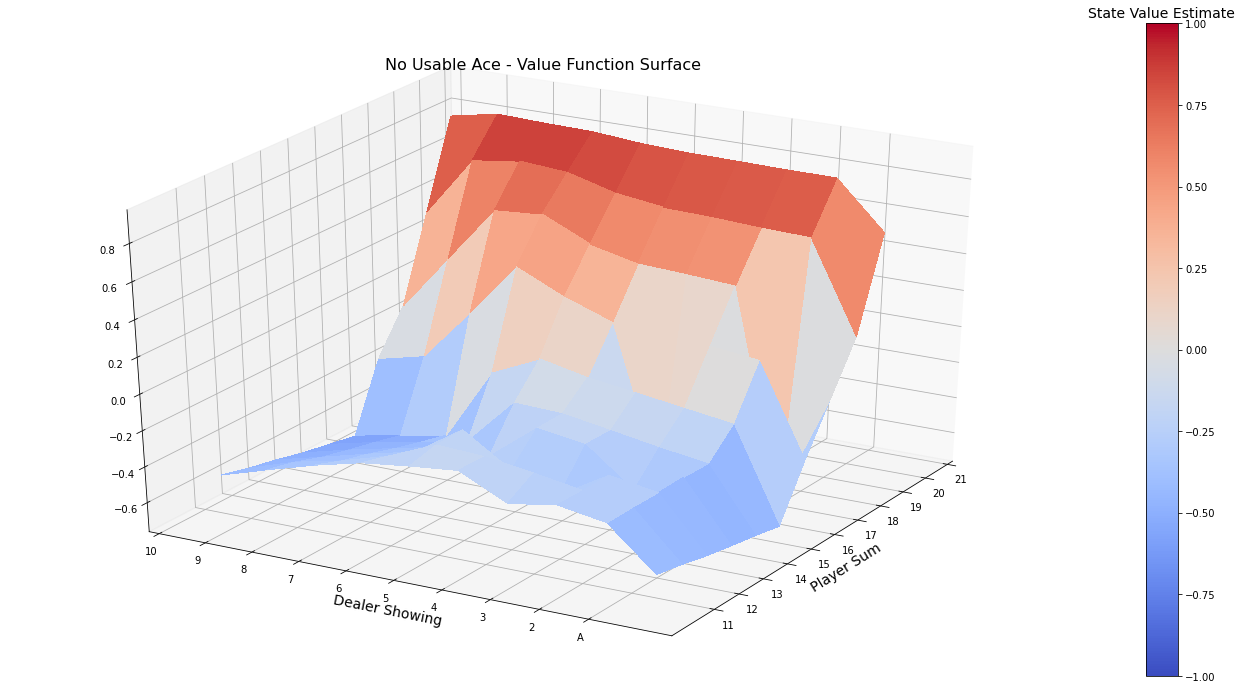

In [100]:
# No Usable Ace - Value function surface

# NB: We need to use these ranges because the index in the action_value tensor 
#     corresponds to state repsentation (e.g., the action value for player_score=12, 
#     dealer_card=3, usable_ace=1 is stored at agent.action_values[12, 3, 1]).
x = np.arange(12, 22)
y = np.arange(1, 11)
X, Y = np.meshgrid(x, y)

# Estimate the value function by following our deterministic action-value maximizing policy
Z = np.amax(agent.action_values[X, Y, 0], axis=2)

# Need to recompute the X & Y meshgrids so we can properly index into the Z tensor
x = np.arange(0, 10)
y = np.arange(0, 10)
X, Y = np.meshgrid(x, y)

surface_plot(X=X,
             Y=Y,
             Z=Z,
             x_labels=player_labels, 
             y_labels=dealer_labels, 
             x_title=player_title, 
             y_title=dealer_title, 
             title="No Usable Ace - Value Function Surface")

### TODO
- Investigate anomalies (e.g. agent.action_values[19, 2, 0])
- Remove unreachable states from the agent's data strcutures
- Consider refactoring the experiment code to a module (and adding some quality of life stuff, like saving the agent periodically)